![](http://mymommyology.com/wp-content/uploads/2011/06/dora-the-explorer-logo1.jpg)

In [24]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#added this because it's indicated as useful but not imported
import urllib
from zipfile import ZipFile
from io import BytesIO
import os
import json
from bs4 import BeautifulSoup as bs
import re

from matplotlib import animation, rc
from IPython.display import display, HTML

I Definitely copy and pasted this next piece. I found it here:
http://stackoverflow.com/a/13895723

In [25]:
def reporthook(blocknum, blocksize, totalsize):
    readsofar = blocknum * blocksize
    if totalsize > 0:
        percent = readsofar * 1e2 / totalsize
        s = "\r%5.1f%% %*d / %d" % (
            percent, len(str(totalsize)), readsofar, totalsize)
        os.sys.stderr.write(s)
        if readsofar >= totalsize: # near the end
            os.sys.stderr.write("\n")
    else: # total size is unknown
        os.sys.stderr.write("read %d\n" % (readsofar,))

In [26]:
datadir = "data"
try:
    os.makedirs(datadir)
except:
    pass #directory already exists. :P

## Q1: Is gentrification the cause of rent hikes in Crown Heights, Brooklyn?

In [27]:
#how do we answer this?

## Q2: Are new people moving in below the median income?

In [28]:
%%script false
some_zip_files = ["https://www.huduser.gov/portal/datasets/fmr/fmr2016p/asq_zctadata_2013_00000to19999.zip",
                 "https://www.huduser.gov/portal/datasets/fmr/fmr2017/FY2017_hypothetical_safmrs.xlsx"]

In [29]:
%%script false
#my attempt at data caching
for some_zip_file in some_zip_files:
    try:
        zipF = ZipFile(os.path.join(datadir,some_zip_file.split("/")[-1]))
    except FileNotFoundError as e:
        #if zip doesn't exist, download it and try opening it again
        urllib.request.urlretrieve(some_zip_file, os.path.join(datadir,some_zip_file.split("/")[-1]), reporthook)
        zipF = ZipFile(os.path.join(datadir,some_zip_file.split("/")[-1]))
    print(zipF.namelist())

Extracting is extra slow too

In [30]:
#some_df = pd.read_excel(os.path.join(datadir,some_zip_files[1].split("/")[-1]))

In [31]:
#some_df.head()

In [32]:
#"https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_14_5YR_S1901&prodType=table"

Use the Census wrapper

In [33]:
with open("keys.json") as json_file:    
    keys = json.load(json_file)
census_key = keys["census"]["api_key"]

### Get zipcodes into dataframe

In [34]:
%%script false
ziphtml = urllib.request.urlopen("https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm").read().decode('utf-8')
soup = bs(ziphtml, 'html.parser')
borough = ""
zipcodes = []
for row in soup.find_all('tr'):
    cols = row.find_all('td')
    if len(cols) == 3:
        borough = cols[0].text
        neighborhood = cols[1].text
        for zipcode in re.compile("\s*,\s*").split(cols[2].text):
            zipcodes.append({"borough": borough, "neighborhood": neighborhood, "zipcode": zipcode})
    elif len(cols) == 2:
        neighborhood = cols[0].text
        for zipcode in re.compile("\s*,\s*").split(cols[1].text):
            zipcodes.append({"borough": borough, "neighborhood": neighborhood, "zipcode": zipcode})
    else:
        print(cols)
zipDF = pd.DataFrame(zipcodes)
zipDF.head()

In [35]:
bkzips = "http://www.brooklyn.com/zipcodes.php"
ziphtml = urllib.request.urlopen(bkzips).read().decode('utf-8')
soup = bs(ziphtml, 'html.parser')
borough = ""
zipcodes = []
for row in soup.find_all('tr'):
    cols = row.find_all('td')
    if len(cols) >= 2:
        neighborhood = cols[0].text.replace("\n", "")
        for zipcode in re.compile("\s*,\s*").split(cols[1].text):
            zipcodes.append({"neighborhood": neighborhood, "zipcode": zipcode})
    else:
        print(cols)
zipDF = pd.DataFrame(zipcodes)
zipDF.head()

[]


,neighborhood,zipcode
0,Albemarle-Kenmore Terrace,11226
1,Bath Beach,11214
2,Bay Ridge,11209
3,Bedford Stuyvesant,11216
4,Bensonhurst,11214


In [36]:
#zipDF[zipDF.borough == "Brooklyn"].zipcode.values

### WTF is this newb stuff?!

In [37]:
census_vars = json.loads(urllib.request.urlopen("http://api.census.gov/data/2014/acs5/variables.json").read().decode('utf-8'))["variables"]
income_brackets = dict([(key, value["label"]) for key, value in census_vars.items() if "B19001_" in key and key[-1] == "E"])

In [38]:
from us import states
from census import Census

def getincome20xx(income_brackets, years, census_key, zips):
    c = Census(census_key)
    df = pd.DataFrame()
    for year in years:
        tempget = c.acs5.zipcode((tuple([key[0] for key in income_brackets.items()])), Census.ALL, year=year)
        tempDF = pd.DataFrame(tempget)
        tempDF.columns = [income_brackets[tempDF.columns[i]] if i < len(income_brackets) else tempDF.columns[i] for i in range(len(tempDF.columns))]
        tempDF = tempDF[tempDF[tempDF.columns[-1]].isin(zips)]
        tempDF["year"] = year
        df = df.append(tempDF)
    return df

In [39]:
#let's just get Brooklyn zips for now
#theDF = getincome20xx(income_brackets,range(2011,2015), census_key, zipDF["zipcode"].values)
theDF = getincome20xx(income_brackets,range(2011,2015), census_key, zipDF["zipcode"].unique())

In [40]:
newcols = ["total", "0", "10", "15", "20", "25", "30", "35", "40", "45", "50", "60", "75", "100", "125", "150", "200", "ZIP", "year"]
theDF.columns = newcols
theDF.to_csv(os.path.join(datadir, "incomeDF.csv"))
theDF.head()

,total,0,10,15,20,25,30,35,40,45,50,60,75,100,125,150,200,ZIP,year
2694,23254,1656,706,618,710,403,643,596,686,547,1303,1853,2929,1954,1456,2219,4975,11201,2011
2695,27145,2740,1244,1525,1486,1352,1158,1397,1453,1449,1876,2761,3418,2316,1410,994,566,11203,2011
2696,24979,1939,1920,1705,1564,1580,1373,1333,1223,1038,2025,2536,2655,1572,900,1043,573,11204,2011
2697,14033,2131,1017,874,866,659,614,488,570,324,889,1193,1255,1160,581,640,772,11205,2011
2698,27668,5551,2800,2612,1950,1551,1643,1079,1405,1172,1669,1675,1911,1170,753,478,249,11206,2011


In [41]:
%%script false
testDF = theDF[theDF.zipcode == "11214"]
for year in range(2011, 2015):
    yearDF = testDF[testDF.year==year]
    X = [int(val) for val in yearDF.columns[1:-2]]
    Y = [int(val) for val in yearDF.values[0][1:-2]]
    plt.figure()
    #plt.xticks(range(0,200,20))
    plt.bar(X, Y, linewidth=5, color='b')
#testDF[testDF.year == 2011].hist()

In [42]:
def maxVal(theDF):
    return max([max([int(v) for v in row[1:-2]]) for row in theDF.values])
    
def animateZipcode(hoodDF):
    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure()
    upperBound = maxVal(hoodDF) + 500
    ax = plt.axes(xlim=(0, 200), ylim=(0, upperBound))
    plt.xlabel("Houshold income (x 1000)")
    plt.ylabel("# of Housholds")
    #get zipcode
    zipcode = hoodDF.ZIP.values[0]
    #neighborhood = zipDF[zipDF.zipcode == zipcode].neighborhood.values[0]
    plt.title("Income changes over time in " + zipcode)
    line, = ax.plot([], [], lw=2)
    year_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
    
    # initialization function: plot the background of each frame
    def init():
        line.set_data([], [])
        year_text.set_text('')
        return line,

    # animation function.  This is called sequentially
    def animate(i):
        yearDF = hoodDF[hoodDF.year==(2011+i)]
        X = [int(val) for val in yearDF.columns[1:-2]]
        Y = [int(val) for val in yearDF.values[0][1:-2]]
        line.set_data(X, Y)
        year_text.set_text(str(2011+i))
        return line,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=4, interval=1000, blit=True)
    display(HTML(anim.to_html5_video()))
    
    return anim

Number of animations: 36


RuntimeError: No MovieWriters available!

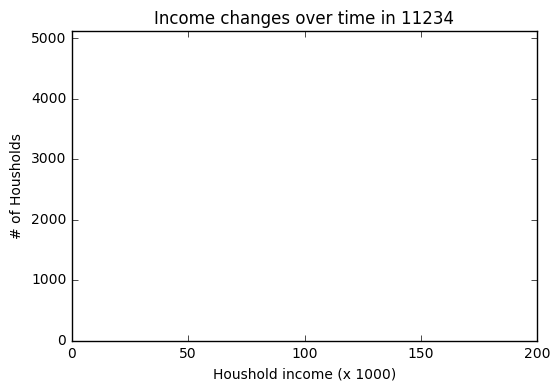

In [43]:
allzips = set(theDF.ZIP.values)
print("Number of animations: " + str(len(allzips)))
for zipcode in allzips:
    anim = animateZipcode(theDF[theDF.ZIP == zipcode])
    anim.save("data/"+str(zipcode)+".mp4")
print("==================================")
print("Why these still images?")
print("==================================")

## Q3: How much do they contribute to the taxi industry?
#### Let's make this more specific, maybe?

In [ ]:
#taxi_url="https://data.cityofnewyork.us/resource/2yzn-sicd.json"

In [ ]:
#taxi_df = pd.read_json(taxi_url)

### What does the data look like?

In [ ]:
#taxi_df.head()